# mount drive and configure envs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/GL-GenAI/Week13-AdvancedGenAI/langgraphTutorials')
os.listdir()

['Copy of empty.ipynb', '.env', 'langChainAgent.ipynb', 'langGraphAgent.ipynb']

In [122]:
# %%writefile .env
# OPENAI_API_KEY=""
# LANGSMITH_API_KEY=""
# LANGSMITH_TRACING=true
# AGENT_API_KEY=""


In [4]:
pip install -q python-dotenv

In [5]:
import openai
from dotenv import load_dotenv

In [74]:
# Set environment variable to avoid tokenizer warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Force reload of environment variables
load_dotenv(override=True)

True

In [123]:
# Set the OpenAI API key from the environment variable
openai.api_key = os.getenv('OPENAI_API_KEY')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
LANGSMITH_TRACING = os.getenv('LANGSMITH_TRACING')
AGENT_API_KEY = os.getenv('AGENT_API_KEY')

# print(openai.api_key)   # only for testing
# print(LANGSMITH_API_KEY)
# print(LANGSMITH_TRACING)
# print(AGENT_API_KEY)

# References:



In [ ]:
https://www.youtube.com/watch?v=QX_HOTYQtQc
https://www.youtube.com/watch?v=O5xqHezaVoA
https://www.youtube.com/watch?v=bZcvUxSd7oc


# Start exercise

## Installing langsmith also, so, we can see: **LangGraph agent with LangSmith**

In [26]:
!pip install langchain langsmith langchain-community langgraph openai langchain_openai wikipedia

In [27]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

In [28]:
api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_context_chars_max=100)
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

## test out the tool with tool.run command

In [29]:
wiki_tool.run({"query" : "AI agents"})

'Page: Intelligent agent\nSummary: In artificial intelligence, an intelligent agent is an entity that perceives its environment, takes actions autonomously to achieve goals, and may improve its performance through machine learning or by acquiring knowledge. Leading AI textbooks define artificial intelligence as the "study and design of intelligent agents," emphasizing that goal-directed behavior is central to intelligence.\nA specialized subset of intelligent agents, agentic AI (also known as an AI agent or simply agent), expands this concept by proactively pursuing goals, making decisions, and taking actions over extended periods, thereby exemplifying a novel form of digital agency.\nIntelligent agents can range from simple to highly complex. A basic thermostat or control system is considered an intelligent agent, as is a human being, or any other system that meets the same criteria—such as a firm, a state, or a biome.\nIntelligent agents operate based on an objective function, which 

## initialize the llm

In [30]:
from langchain_openai import ChatOpenAI as chatOpenAI

In [15]:
llm = chatOpenAI(temperature=0, openai_api_key=openai.api_key, model_name="gpt-4o-mini")

## Now bind the llm to the tool
- if you don't have the answer, then use the tool to answer the user query

In [31]:
from rich import print # for nice printing

tools = [wiki_tool] # was defined earlier

# tool binding
llm_with_tools = llm.bind_tools(tools)

# tool calling
result = llm_with_tools.invoke("Hello world!")
print(f"full result: {result}")
print("\n" * 2)
print(f"[green][bold]✅ show content only from result: {result.content}[/bold][/green]")



full result: content='Hello! How can I assist you today?' additional_kwargs={'refusal': None} 
response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 84, 'total_tokens': 95, 
'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 
'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 
'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None} 
id='run-92a1998c-b8db-4701-bdac-e4b48e506654-0' usage_metadata={'input_tokens': 84, 'output_tokens': 11, 
'total_tokens': 95, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 
'reasoning': 0}}

✅ show content only from result: Hello! How can I assist you today?

**Observation:**
- notice that tool call was not needed here

## Now create an agent to use tool when needed
- tool binding to llm was already done:  
```llm_with_tools = llm.bind_tools(tools)```

**llm.bind_tools versus create_react_agent**

	•	llm.bind_tools(tools): Creates an LLM that can directly call tools.
	•	create_react_agent(llm, tools): Creates an agent that makes decisions about calling tools.

📌 The agent is responsible for deciding when and how to call tools rather than the LLM doing it automatically.

Why Not Use llm_with_tools in create_react_agent()?

	•	The agent manages tools itself, so binding tools separately is unnecessary.
	•	create_react_agent() directly passes the tools to the agent, which internally manages their execution.

3️⃣ When Should You Use llm_with_tools?

	•	If you’re not using an agent but still want an LLM that can call tools.

4️⃣ When Should You Use create_react_agent(llm, tools)?

	•	When you need structured decision-making.
	•	The agent follows a reasoning process before deciding whether to call tools.
	•	The ReAct agent iterates between reasoning steps before returning a final response.   

## 🚀 Summary: `llm.bind_tools(tools)` vs `create_react_agent(llm, tools)`

| Approach            | **`llm.bind_tools(tools)`**          | **`create_react_agent(llm, tools)`** |
|---------------------|---------------------------------|------------------------------------|
| **Purpose**        | Enables tool use directly in the LLM | Creates an agent that decides tool use |
| **LLM Involvement** | LLM **directly** decides to use tools | Agent **controls** when tools are used |
| **When to Use?**    | If using an LLM **without an agent** | If using a **structured decision-making agent** |
| **Needed for Agents?** | ❌ No | ✅ Yes |

🔹 **If using an agent (`create_react_agent()`), you don’t need `bind_tools()` because the agent already handles tool calling.**  
🔹 **If using only the LLM (`llm.invoke()`), then `bind_tools()` allows the LLM to use tools automatically.**  

### import ReACT agent first

In [32]:
from langgraph.prebuilt import create_react_agent

- create ***`agent_executor`***

In [33]:
agent_executor = create_react_agent(llm, tools) # tools = [wiki_tool] # was defined earlier

## test the agent

In [34]:
from langchain_core.messages import HumanMessage

# First we will ask a question where no tool call is needed

response = agent_executor.invoke({"messages" :  [HumanMessage(content = "Hello world!")]})
print(response["messages"])

[
    HumanMessage(
        content='Hello world!',
        additional_kwargs={},
        response_metadata={},
        id='7d0e7636-353c-4d90-a71b-3aa6115fc594'
    ),
    AIMessage(
        content='Hello! How can I assist you today?',
        additional_kwargs={'refusal': None},
        response_metadata={
            'token_usage': {
                'completion_tokens': 11,
                'prompt_tokens': 84,
                'total_tokens': 95,
                'completion_tokens_details': {
                    'accepted_prediction_tokens': 0,
                    'audio_tokens': 0,
                    'reasoning_tokens': 0,
                    'rejected_prediction_tokens': 0
                },
                'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
            },
            'model_name': 'gpt-4o-mini-2024-07-18',
            'system_fingerprint': 'fp_06737a9306',
            'finish_reason': 'stop',
            'logprobs': None
        },
        id='run-3fbfc125-7607-4880-86a3-d32e03cb15f9-0',
        usage_metadata={
            'input_tokens': 84,
            'output_tokens': 11,
            'total_tokens': 95,
            'input_token_details': {'audio': 0, 'cache_read': 0},
            'output_token_details': {'audio': 0, 'reasoning': 0}
        }
    )
]

In [35]:
print(response["messages"][-1].content)


Hello! How can I assist you today?

**Observation:**
- no tool was used

## Now let's ask a question that requires tools

In [36]:
response = agent_executor.invoke({"messages" :  [HumanMessage(content = "what is agentic AI ?")]})
print(response["messages"])

[
    HumanMessage(
        content='what is agentic AI ?',
        additional_kwargs={},
        response_metadata={},
        id='e1d22ca0-6497-4c92-a886-229bbe1f3254'
    ),
    AIMessage(
        content='',
        additional_kwargs={
            'tool_calls': [
                {
                    'id': 'call_SQ8f1WkpSYEV8H754xXUWI14',
                    'function': {'arguments': '{"query":"Agentic AI"}', 'name': 'wikipedia'},
                    'type': 'function'
                }
            ],
            'refusal': None
        },
        response_metadata={
            'token_usage': {
                'completion_tokens': 16,
                'prompt_tokens': 87,
                'total_tokens': 103,
                'completion_tokens_details': {
                    'accepted_prediction_tokens': 0,
                    'audio_tokens': 0,
                    'reasoning_tokens': 0,
                    'rejected_prediction_tokens': 0
                },
                'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
            },
            'model_name': 'gpt-4o-mini-2024-07-18',
            'system_fingerprint': 'fp_06737a9306',
            'finish_reason': 'tool_calls',
            'logprobs': None
        },
        id='run-dbeed222-9ef7-4fb2-ab26-47774202a5be-0',
        tool_calls=[
            {
                'name': 'wikipedia',
                'args': {'query': 'Agentic AI'},
                'id': 'call_SQ8f1WkpSYEV8H754xXUWI14',
                'type': 'tool_call'
            }
        ],
        usage_metadata={
            'input_tokens': 87,
            'output_tokens': 16,
            'total_tokens': 103,
            'input_token_details': {'audio': 0, 'cache_read': 0},
            'output_token_details': {'audio': 0, 'reasoning': 0}
        }
    ),
    ToolMessage(
        content='Page: Agentic AI\nSummary: Agentic AI is a class of artificial intelligence that focuses on 
autonomous systems that can make decisions and perform tasks without human intervention. The independent systems 
automatically respond to conditions, to produce process results. The field is closely linked to agentic automation,
also known as agent-based process management systems (APMS), when applied to process automation. Applications 
include software development, customer support, cybersecurity and business intelligence.\n\n',
        name='wikipedia',
        id='3f103a09-8e70-465f-8dee-f833b12e19fb',
        tool_call_id='call_SQ8f1WkpSYEV8H754xXUWI14'
    ),
    AIMessage(
        content='Agentic AI refers to a class of artificial intelligence that emphasizes autonomous systems capable
of making decisions and performing tasks without human intervention. These systems can automatically respond to 
various conditions to produce results. Agentic AI is closely related to agentic automation, also known as 
agent-based process management systems (APMS), particularly in the context of process automation. Common 
applications of agentic AI include software development, customer support, cybersecurity, and business 
intelligence.',
        additional_kwargs={'refusal': None},
        response_metadata={
            'token_usage': {
                'completion_tokens': 89,
                'prompt_tokens': 197,
                'total_tokens': 286,
                'completion_tokens_details': {
                    'accepted_prediction_tokens': 0,
                    'audio_tokens': 0,
                    'reasoning_tokens': 0,
                    'rejected_prediction_tokens': 0
                },
                'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
            },
            'model_name': 'gpt-4o-mini-2024-07-18',
            'system_fingerprint': 'fp_06737a9306',
            'finish_reason': 'stop',
            'logprobs': None
        },
        id='run-8445e8f6-5595-4cd3-9add-a7471734b6f5-0',
        usage_metadata={
            'input_tokens': 197,
            'output_tokens': 89,
      

In [ ]:
print(response["messages"][-1].content)

Agentic AI refers to a class of artificial intelligence that emphasizes autonomous systems capable of making 
decisions and performing tasks without human intervention. These systems can automatically respond to various 
conditions to produce results. Agentic AI is closely related to agentic automation, also known as agent-based 
process management systems (APMS), particularly in the context of process automation. Common applications of 
agentic AI include software development, customer support, cybersecurity, and business intelligence.

**Observation:**
- now tool was used

**Summary**
- here langchain was used to create an agent and use it (other than ReACT agent that was imported from langgraph)
- no nodes/edge for langgraph was created (so basically this is a langchain demo)

# Moving on to actual LangGraph with Nodes/Edges

In [43]:
!pip install iPython

In [118]:
from IPython.display import Image, display # view graph
from langgraph.graph import StateGraph, START # StateMachine # the StateGraph will show in langsmith: https://smith.langchain.com/
from langchain_openai import ChatOpenAI as chatOpenAI
import requests

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState

from langgraph.prebuilt import ToolNode, tools_condition


from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

## export to langsmith
- https://smith.langchain.com/

In [115]:
pip install -q langchain langchain-openai

In [117]:
LANGSMITH_TRACING = LANGSMITH_TRACING
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
LANGSMITH_API_KEY= LANGSMITH_API_KEY
LANGSMITH_PROJECT="LangGraph-demo"
OPENAI_API_KEY= openai.api_key

## Now create State (memory where all message states will be stored)

In [47]:
class State(TypedDict):
    messages: Annotated[list, add_messages] # all messages from bot and user will be stored

## write a code for tool

In [96]:
!pip install -U duckduckgo-search


from langchain_community.tools import DuckDuckGoSearchRun


In [97]:
# search = DuckDuckGoSearchRun()
# search.invoke("what is langchain?")

## Let's create a function

In [98]:
# import time

# def search_duckduckgo(query: str) -> str:
#   """Searches DuckDuckGo and returns the first result."""
#   search = DuckDuckGoSearchRun()
#   try:
#     return search.invoke(query)
#   except Exception as e:
#     if "Ratelimit" in str(e):
#       print("Rate limit exceeded. Waiting for 5 seconds...")
#       time.sleep(5)  # Wait for 5 seconds before retrying
#       return search_duckduckgo(query)  # Retry the search
#     else:
#       raise e  # Re-raise the exception if it's not a rate limit error



In [99]:
# Example usage
# result = search_duckduckgo("what is langchain?")
# print(result)

## Create your own tool

In [100]:
def multiply(a:int,b:int) -> int:
  """
  Multiply a and b
  """

  return a*b

In [101]:
def add(a:int,b:int) -> int:
  "Add a and b"
  return a+b

In [102]:
import random

def random_int() -> int:
    """Generate a random integer between 1 and 1000."""
    return random.randint(1, 1000)

## Define LLM

In [103]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(temperature=0, openai_api_key=openai.api_key, model_name="gpt-4o-mini")

In [104]:
# check that it's working
llm.invoke('hello').content

'Hello! How can I assist you today?'

## Define tools

In [105]:
tools = [add, multiply, random_int]

## Bind the tools

In [106]:
llm_with_tools = llm.bind_tools(tools)

## define function to use tools
- note, here we are not defining agent_executor, like we did before with langchain

```agent_executor = create_react_agent(llm, tools)```

In [107]:

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

## Now create your langraph nodes/edges

In [108]:
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State) # memory

# Define nodes
graph_builder.add_node("assistant",chatbot) # adding chatbot as a node (name of node is assistant)
graph_builder.add_node("tools",ToolNode(tools)) # adding tools as a node (name of node is tools)

#define edges
graph_builder.add_edge(START,"assistant") # create connection (edge) between START node and assistant node
graph_builder.add_conditional_edges("assistant",tools_condition) # create connection (edge) between assistant node and tools_conditions node
graph_builder.add_edge("tools","assistant") # add connection (edge) between tools and assistant

react_graph=graph_builder.compile()

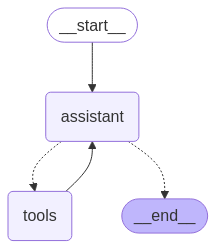

In [109]:

# To see the graph’s connection visually

display(Image(react_graph.get_graph().draw_mermaid_png()))

## use the tools with langgraph

In [110]:
import rich

### remember we had done this before:
- react_graph=graph_builder.compile()

In [119]:
response = react_graph.invoke({"messages": [

    SystemMessage(content="You are an answerer  You only give final answer with no explanations."),
    HumanMessage(content="generate a random number. Multiply it by 2 and add 5.")

    ]

})
print(response["messages"])

[
    SystemMessage(
        content='You are an answerer  You only give final answer with no explanations.',
        additional_kwargs={},
        response_metadata={},
        id='69b80ffa-0e17-4575-90a3-6ed362d0a099'
    ),
    HumanMessage(
        content='generate a random number. Multiply it by 2 and add 5.',
        additional_kwargs={},
        response_metadata={},
        id='b8bb78f0-199a-44ab-bd98-40aa2725120e'
    ),
    AIMessage(
        content='',
        additional_kwargs={
            'tool_calls': [
                {
                    'id': 'call_JAkzOMVh9jv83PIisD4WlZMz',
                    'function': {'arguments': '{}', 'name': 'random_int'},
                    'type': 'function'
                }
            ],
            'refusal': None
        },
        response_metadata={
            'token_usage': {
                'completion_tokens': 11,
                'prompt_tokens': 117,
                'total_tokens': 128,
                'completion_tokens_details': {
                    'accepted_prediction_tokens': 0,
                    'audio_tokens': 0,
                    'reasoning_tokens': 0,
                    'rejected_prediction_tokens': 0
                },
                'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
            },
            'model_name': 'gpt-4o-mini-2024-07-18',
            'system_fingerprint': 'fp_06737a9306',
            'finish_reason': 'tool_calls',
            'logprobs': None
        },
        id='run-8c86abfe-5503-4e3e-bcf8-9883246a84f9-0',
        tool_calls=[
            {'name': 'random_int', 'args': {}, 'id': 'call_JAkzOMVh9jv83PIisD4WlZMz', 'type': 'tool_call'}
        ],
        usage_metadata={
            'input_tokens': 117,
            'output_tokens': 11,
            'total_tokens': 128,
            'input_token_details': {'audio': 0, 'cache_read': 0},
            'output_token_details': {'audio': 0, 'reasoning': 0}
        }
    ),
    ToolMessage(
        content='82',
        name='random_int',
        id='bbf1ed6f-a76c-4aaf-9312-d3fb5473bc59',
        tool_call_id='call_JAkzOMVh9jv83PIisD4WlZMz'
    ),
    AIMessage(
        content='',
        additional_kwargs={
            'tool_calls': [
                {
                    'id': 'call_d7zhM74dWg81ql0prknDvwIH',
                    'function': {'arguments': '{"a": 82, "b": 2}', 'name': 'multiply'},
                    'type': 'function'
                },
                {
                    'id': 'call_bmdYpz5e0p7CfKczCpDsibMr',
                    'function': {'arguments': '{"a": 164, "b": 5}', 'name': 'add'},
                    'type': 'function'
                }
            ],
            'refusal': None
        },
        response_metadata={
            'token_usage': {
                'completion_tokens': 51,
                'prompt_tokens': 136,
                'total_tokens': 187,
                'completion_tokens_details': {
                    'accepted_prediction_tokens': 0,
                    'audio_tokens': 0,
                    'reasoning_tokens': 0,
                    'rejected_prediction_tokens': 0
                },
                'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
            },
            'model_name': 'gpt-4o-mini-2024-07-18',
            'system_fingerprint': 'fp_06737a9306',
            'finish_reason': 'tool_calls',
            'logprobs': None
        },
        id='run-c961aed1-e25f-41e6-81b2-0578cb4c2db8-0',
        tool_calls=[
            {
                'name': 'multiply',
                'args': {'a': 82, 'b': 2},
                'id': 'call_d7zhM74dWg81ql0prknDvwIH',
                'type': 'tool_call'
            },
            {
                'name': 'add',
                'args': {'a': 164, 'b': 5},
                'id': 'call_bmdYpz5e0p7CfKczCpDsibMr',
                'type': 'tool_call'
            }
        ],
        usage_metadata={
            'input_tokens': 136,
            'output_toke

In [120]:
print(response["messages"][-1].content)

169

**Observation:**

**Tools were called dynamically**